### Volatilidade histórica
A Volatilidade histórica simples é uma forma fácil de se obter uma estimativa de Volatilidade, utiliza-se do desvio padrão
de retornos de períodos determinados. 
Por exemplo, pode-se utilizar retornos diários ou mensais para se obter a Volatilidade anual.

Dada uma lista com os $n$ preços históricos de um ativo, $X$, vamos chamar de $x_i$ o preço de cada dia.

Calculamos a série de log retornos:

$$u_i = ln(\frac{x_i}{x_{i-1}})$$

Agora com a série $U$ de log retornos, vamos calcular seu desvio padrão:

$$\sigma^{2} = \frac{1}{n-1} \sum_{i=1}^{n} (u_i - \bar{u})^2$$

Sendo $\sigma$ a Volatilidade diária do nosso ativo. Podemos multiplicar por $ \sqrt{252}$ para obter a Volatilidade anual.

In [103]:
pd.options.display.float_format = '{:20,.10f}'.format

In [57]:
#primeiro vamos coletar alguns dados

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

stocks = yf.Ticker("MGLU3.SA")
hist = stocks.history(period="12mo")

In [58]:
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-14,24.132499,24.142492,23.482970,23.712803,25548400,0.0,0
2021-01-15,23.712804,24.092529,23.333080,23.942636,32761100,0.0,0
2021-01-18,24.032572,24.632137,23.892674,24.432283,24257200,0.0,0
2021-01-19,24.522217,24.931920,23.802738,24.062550,21025600,0.0,0
2021-01-20,24.162478,25.511500,24.102522,25.401579,48089300,0.0,0
...,...,...,...,...,...,...,...
2022-01-10,6.140000,6.150000,5.740000,5.740000,114384500,0.0,0
2022-01-11,5.750000,6.010000,5.720000,5.870000,142963700,0.0,0
2022-01-12,5.900000,6.370000,5.780000,6.310000,127342800,0.0,0


In [259]:
#preparar
df = hist[['Close']].copy()
df.columns = ['Preco']
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime( df['Date'])
df

,Date,Preco
0,2021-01-14,23.7128028870
1,2021-01-15,23.9426364899
2,2021-01-18,24.4322834015
3,2021-01-19,24.0625495911
4,2021-01-20,25.4015789032
...,...,...
244,2022-01-10,5.7399997711
245,2022-01-11,5.8699998856
246,2022-01-12,6.3099999428
247,2022-01-13,6.0900001526


In [260]:
df['PD1'] = df['Preco'].shift(1)
df['LgRet'] = np.log(df['Preco']/df['PD1'])
df

,Date,Preco,PD1,LgRet
0,2021-01-14,23.7128028870,NaN,NaN
1,2021-01-15,23.9426364899,23.7128028870,0.0096457147
2,2021-01-18,24.4322834015,23.9426364899,0.0202445249
3,2021-01-19,24.0625495911,24.4322834015,-0.0152486750
4,2021-01-20,25.4015789032,24.0625495911,0.0541546607
...,...,...,...,...
244,2022-01-10,5.7399997711,6.2199997902,-0.0803107026
245,2022-01-11,5.8699998856,5.7399997711,0.0223954439
246,2022-01-12,6.3099999428,5.8699998856,0.0722810531
247,2022-01-13,6.0900001526,6.3099999428,-0.0354875607


In [287]:
variancia = df['LgRet'].var()
variancia

0.001375623255153521

In [288]:
vol1 = np.sqrt(variancia)
vol1

0.037089395454139196

In [289]:
vol1 * np.sqrt(252)

0.5887758998962911

#### Algumas simplificações:

É possível simplificar um pouco o cálculo se adotarmos algumas premissas:

- A média de retornos é igual a 0
- Usar $n$ ao invés de $n-1$

Com estas alterações, nossa fórmula se torna:

$$\sigma^{2} = \frac{1}{n} \sum_{i=1}^{n} u_i^2$$

Repare que é basicamente uma média simples do quadrado dos retornos.

In [264]:
vol2 = np.sqrt((df['LgRet']**2).sum()/249)
vol2

0.03732051357246292

In [265]:
vol2 * np.sqrt(252)

0.5924447862836857

In [266]:
(vol2 * np.sqrt(252) - np.sqrt(variancia) * np.sqrt(252))*100

0.36688863873945987

#### Críticas ao modelo Simples

A crítica óbvia, claro, é que o modelo é simples, ele pressupõe que movimentos acontecidos no passado em momentos
diferentes tem mesmo peso na determinação do futuro. 

Por exemplo, se um ativo teve um dia em que seu retorno foi de 9%, 
não haverá diferença caso este dia tenha ocorrido ontem ou há 3 meses.

Vamos tentar evoluir nosso modelo de forma a tentar incorporar algumas soluções.



### 2.2 Média móvel exponencial ponderada EWMA

Para resolver a questão de que dados de dias mais antigos deveriam ter menor influência na Volatilidade, define-se um modelo
que pondera os retornos usando pesos com decaimento exponencial. Ou seja, o dia mais recente tem um peso maior no cálculo e 
os dias anteriores terão pesos menores.

Esse modelo é chamado Exponentially Weighted Moving Average (EWMA) e para controlar estes pesos é introduzido o parâmetro $\lambda$ que é chamado de parâmetro de suavização (smoothing paramenter). 

![Modelos de Volatilidade](E:\gusta\Documents\GitHub\financas\Imagens\14_02_EWMA.png)

Repare na figura que cada retorno utiliza pesos de valores diferentes, determinados por $\lambda$.

De forma que ao considerar todos os pesos teremos:

$$\sigma^{2} = \sum_{i=0}^{n} u_i^2 (1-\lambda)\lambda^i$$



é importante notar a ordem dos índices, que deve ser invertida, o índice 0 será o período mais recente, 1 o do período anterior e assim sucessivamente.

Uma vantagem da EWMA é que ela pode ser calculada de forma recursiva:

$$\sigma_i^{2} = (1-\lambda)u_{i-1}^2 + \lambda \sigma_{i-1}^2$$

O valor de $\sigma^2$ no tempo $i$ é definido pelo valor de $\sigma^2$ no período anterior + o retorno do período anterior, ponderados por $\lambda$.


In [291]:
df['u2'] = df['LgRet']**2
df

,Date,Preco,PD1,LgRet,u2,delta,peso,pre_vol
0,2021-01-14,23.7128028870,NaN,NaN,NaN,248,0.0000000000,NaN
1,2021-01-15,23.9426364899,23.7128028870,0.0096457147,0.0000930398,247,0.0000000000,0.0000000000
2,2021-01-18,24.4322834015,23.9426364899,0.0202445249,0.0004098408,246,0.0000000000,0.0000000000
3,2021-01-19,24.0625495911,24.4322834015,-0.0152486750,0.0002325221,245,0.0000000000,0.0000000000
4,2021-01-20,25.4015789032,24.0625495911,0.0541546607,0.0029327273,244,0.0000000000,0.0000000000
...,...,...,...,...,...,...,...,...
244,2022-01-10,5.7399997711,6.2199997902,-0.0803107026,0.0064498089,4,0.0468449376,0.0003021409
245,2022-01-11,5.8699998856,5.7399997711,0.0223954439,0.0005015559,3,0.0498350400,0.0000249951
246,2022-01-12,6.3099999428,5.8699998856,0.0722810531,0.0052245506,2,0.0530160000,0.0002769848
247,2022-01-13,6.0900001526,6.3099999428,-0.0354875607,0.0012593670,1,0.0564000000,0.0000710283


In [292]:
import datetime as dt
lmbda = 0.94
#df['delta'] = abs(df['Date'].dt.date - dt.date(2022, 1, 14)).dt.days
n = len(df['u2'])
df['delta'] = np.arange(n-1, -1, -1)
df


,Date,Preco,PD1,LgRet,u2,delta,peso,pre_vol
0,2021-01-14,23.7128028870,NaN,NaN,NaN,248,0.0000000000,NaN
1,2021-01-15,23.9426364899,23.7128028870,0.0096457147,0.0000930398,247,0.0000000000,0.0000000000
2,2021-01-18,24.4322834015,23.9426364899,0.0202445249,0.0004098408,246,0.0000000000,0.0000000000
3,2021-01-19,24.0625495911,24.4322834015,-0.0152486750,0.0002325221,245,0.0000000000,0.0000000000
4,2021-01-20,25.4015789032,24.0625495911,0.0541546607,0.0029327273,244,0.0000000000,0.0000000000
...,...,...,...,...,...,...,...,...
244,2022-01-10,5.7399997711,6.2199997902,-0.0803107026,0.0064498089,4,0.0468449376,0.0003021409
245,2022-01-11,5.8699998856,5.7399997711,0.0223954439,0.0005015559,3,0.0498350400,0.0000249951
246,2022-01-12,6.3099999428,5.8699998856,0.0722810531,0.0052245506,2,0.0530160000,0.0002769848
247,2022-01-13,6.0900001526,6.3099999428,-0.0354875607,0.0012593670,1,0.0564000000,0.0000710283


In [293]:
df['peso'] = (1-lmbda )* np.power(lmbda, df['delta'])

df

,Date,Preco,PD1,LgRet,u2,delta,peso,pre_vol
0,2021-01-14,23.7128028870,NaN,NaN,NaN,248,0.0000000130,NaN
1,2021-01-15,23.9426364899,23.7128028870,0.0096457147,0.0000930398,247,0.0000000138,0.0000000000
2,2021-01-18,24.4322834015,23.9426364899,0.0202445249,0.0004098408,246,0.0000000147,0.0000000000
3,2021-01-19,24.0625495911,24.4322834015,-0.0152486750,0.0002325221,245,0.0000000156,0.0000000000
4,2021-01-20,25.4015789032,24.0625495911,0.0541546607,0.0029327273,244,0.0000000166,0.0000000000
...,...,...,...,...,...,...,...,...
244,2022-01-10,5.7399997711,6.2199997902,-0.0803107026,0.0064498089,4,0.0468449376,0.0003021409
245,2022-01-11,5.8699998856,5.7399997711,0.0223954439,0.0005015559,3,0.0498350400,0.0000249951
246,2022-01-12,6.3099999428,5.8699998856,0.0722810531,0.0052245506,2,0.0530160000,0.0002769848
247,2022-01-13,6.0900001526,6.3099999428,-0.0354875607,0.0012593670,1,0.0564000000,0.0000710283


In [294]:
df['pre_vol'] = df['peso'] * df['u2']
df


,Date,Preco,PD1,LgRet,u2,delta,peso,pre_vol
0,2021-01-14,23.7128028870,NaN,NaN,NaN,248,0.0000000130,NaN
1,2021-01-15,23.9426364899,23.7128028870,0.0096457147,0.0000930398,247,0.0000000138,0.0000000000
2,2021-01-18,24.4322834015,23.9426364899,0.0202445249,0.0004098408,246,0.0000000147,0.0000000000
3,2021-01-19,24.0625495911,24.4322834015,-0.0152486750,0.0002325221,245,0.0000000156,0.0000000000
4,2021-01-20,25.4015789032,24.0625495911,0.0541546607,0.0029327273,244,0.0000000166,0.0000000000
...,...,...,...,...,...,...,...,...
244,2022-01-10,5.7399997711,6.2199997902,-0.0803107026,0.0064498089,4,0.0468449376,0.0003021409
245,2022-01-11,5.8699998856,5.7399997711,0.0223954439,0.0005015559,3,0.0498350400,0.0000249951
246,2022-01-12,6.3099999428,5.8699998856,0.0722810531,0.0052245506,2,0.0530160000,0.0002769848
247,2022-01-13,6.0900001526,6.3099999428,-0.0354875607,0.0012593670,1,0.0564000000,0.0000710283


In [296]:
vol3 = np.sqrt(df['pre_vol'].sum())
vol3

0.05190373011014053

<AxesSubplot:>

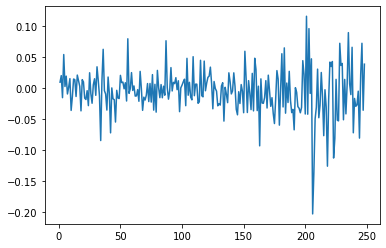

In [295]:
df['LgRet'].plot()

In [297]:
vol3 * np.sqrt(252)

0.8239461719282819

## 3. Volatilidade Implícita (IV)

Sabemos que o valor de um ativo é reflexo do consenso dos participantes com relação ao seu desempenho esperado.
E que podemos considerar até certo ponto que os mercados são eficientes. Então seria possível usar o próprio mercado para 
estimar a Volatilidade do ativo?


Vamos lembrar da equação de Black-Scholes-Merton (BSM) para o preço de uma call/put europeia.


$$  c = S_0 N(d_1) - K e^{-rT} N(d_2) $$

e 

$$ p = K e^{-rT} N(-d_2) - S_0 N(-d_1) $$

Onde:

$$ d_1 = \frac{ ln(S_0/K) + (r + \sigma^2/2) T }{ \sigma \sqrt T} $$

$$ d_2 = \frac{ ln(S_0/K) + (r - \sigma^2/2) T }{ \sigma \sqrt T} = d_1 - \sigma \sqrt T $$

Em que:

A função *N(x)* é a função de distribuição de probabilidade cumulativa para uma variável com distribuição normal padrão. 

- As variáveis *c* e *p* são o preço da opção de compra e da de venda europeias, 
*S_0* é o preço da ação no tempo zero, 
- *K* é o preço de exercício (*strike*), 
- *r* é a taxa de juros livre de risco com capitalização contínua,
- $\sigma$ é a volatilidade do preço da ação e 
- *T* é o tempo até a maturidade da opção.

Perceba que os preços das opções dependem de $\sigma$, um valor de volatividade para o ativo objeto.

Ao invés de usar BSM para obter o preço da opção, nós podemos usar os preços de mercado de uma opção para estimar a Volatilidade que gerou tal preço.

O processo não é simples pois seria difícil isolar $\sigma$ em BSM. Mas é possível usar etapas de otimização da função 
BSM variando $\sigma$ até obter um valor aproximado da opção e dessa forma, usar retornar o $\sigma$.

In [327]:
r = np.log(1 + 0.0925)
r

0.08846864798760819

In [379]:
#MGLU3

print('taxa livre de risco', r)
print('preço da ação', 6.33)
print('preço da opção', 0.06)
print('Strike', 6.99)
print('Tempo', 5/252)

taxa livre de risco 0.08846864798760819
preço da ação 6.33
preço da opção 0.06
Strike 6.99
Tempo 0.01984126984126984


In [390]:
option = BSM('call', 6.33, 6.99,0, r, 25/252, S_ativo=0.27 )

In [391]:
option.vol_impl_()

0.6196627053760406

In [300]:

from   scipy.stats import norm
from   scipy.stats import mvn
import numpy       as     np

class BSM:
    def __init__(self, callput, S, K, sigma=0, r, tau, qrf=None, S_ativo=None):
        self.callput = callput
        self.S = S
        self.K = K
        self.sigma = sigma
        self.r = r
        self.tau = tau
        self.S_ativo = S_ativo
        if qrf is None:
            self.qrf = r
        else:
            self.qrf = qrf
        
    
    def vol_impl_(self):
        if self.S_ativo is None:
            return 0
        else:
            sigma_aux = (np.sqrt(abs(np.log(self.S / self.K) + self.r * self.tau) *\
                         2 / self.tau))
                
            d1_aux = ((np.log(self.S/self.K) +\
                  (self.qrf + sigma_aux**2 / 2) * self.tau) /\
                  (sigma_aux * np.sqrt(self.tau)))
                
            d2_aux = d1_aux - sigma_aux * np.sqrt(self.tau)
            
            if ((self.callput.lower() == 'c') or (self.callput.lower() == 'call')):
                preco_aux = (self.S * np.exp((self.qrf -  self.r) * self.tau) *\
                             norm.cdf(d1_aux) - self.K * np.exp(-self.r * self.tau) *\
                             norm.cdf(d2_aux))
            elif ((self.callput.lower() == 'p') or (self.callput.lower() == 'put')):
                preco_aux = ((self.K * np.exp(-self.r * self.tau) *\
                             norm.cdf(-d2_aux)) - self.S * np.exp((self.qrf -  self.r) *\
                             self.tau) * norm.cdf(-d1_aux))
                                                                  
            vega_aux = (self.S * np.exp((self.qrf - self.r) * self.tau) * norm.pdf(d1_aux) *\
                        np.sqrt(self.tau))
                
            min_diff = abs(self.S_ativo - preco_aux)
            
            eps = 0.0001
            
            while ((abs(self.S_ativo - preco_aux) >= eps) and (abs(self.S_ativo - preco_aux) <= min_diff)):
                sigma_aux = sigma_aux - (preco_aux - self.S_ativo) / vega_aux
                
                d1_aux = ((np.log(self.S/self.K) +\
                          (self.qrf + sigma_aux**2 / 2) * self.tau) /\
                          (sigma_aux * np.sqrt(self.tau)))
                
                d2_aux = d1_aux - sigma_aux * np.sqrt(self.tau)
                
                if ((self.callput.lower() == 'c') or (self.callput.lower() == 'call')):
                    preco_aux = (self.S * np.exp((self.qrf -  self.r) * self.tau) *\
                                 norm.cdf(d1_aux) - self.K * np.exp(-self.r * self.tau) *\
                                 norm.cdf(d2_aux))
                elif ((self.callput.lower() == 'p') or (self.callput.lower() == 'put')):
                    preco_aux = ((self.K * np.exp(-self.r * self.tau) *\
                                  norm.cdf(-d2_aux)) - self.S * np.exp((self.qrf -  self.r) *\
                                  self.tau) * norm.cdf(-d1_aux))
                                                                       
                vega_aux = (self.S * np.exp((self.qrf - self.r) * self.tau) * norm.pdf(d1_aux) *\
                            np.sqrt(self.tau))
                    
                min_diff = abs(self.S_ativo - preco_aux)
                
            if abs(self.S_ativo - preco_aux) <= eps:
                return sigma_aux
            else:
                return 'Não encontrado!'


In [403]:
import numpy as np
from scipy.stats import norm # distribuição normal

def calcula_iv(S, K, r, T, tipo, preco_atual):
    sigmas = np.arange(0.001, 3, 0.001)
    eps = 0.001
    for sigma in sigmas:
        if preco_atual - calc_BS(S, K, r, T, sigma, tipo)<eps:
            return sigma

def calc_BS(S, K, r, T, sigma, tipo):
    # Cálculo do d1
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / sigma*np.sqrt(T)
    # Cálculo do d2
    d2 = d1 - sigma*np.sqrt(T)
    
    if tipo == 'call':
        # Preço se for call (opção de compra)
        price = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    elif tipo == 'put':
        # preço se for put (opção de venda)
        price = K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)
    else:
        # Não sei o tipo, não calculo
        price = None
    
    return price # Preço/prêmio

In [404]:
calcula_iv(6.33, 6.99, r, 25/252, 'call', 0.27)

0.651

In [406]:
calc_BS(6.33, 6.99, r, 25/252, 0.651, 'call')

0.2691661658293403